## MLP model to predict the next character

In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# building the dataset
block_size = 3 # Number of characters we take to make next prediction

def buildDataSet(words):
    X, Y = [], []
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = buildDataSet(words[:n1])
Xdev, Ydev = buildDataSet(words[n1:n2])
Xtest, Ytest = buildDataSet(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
# Parameters
embdSize = 10
vocabSize = len(stoi)
hiddenNeurons = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocabSize, embdSize), generator=g) # Embedding 27 characters into lower dimensional space
W1 = torch.randn(( (embdSize * block_size), hiddenNeurons), generator=g)
b1 = torch.randn(hiddenNeurons, generator=g)
W2 = torch.randn((hiddenNeurons, vocabSize), generator=g)
b2 = torch.randn(vocabSize, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [13]:
maxSteps = 200000
batchSize = 32
lossi = []

for i in range(maxSteps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batchSize,), generator=g)

    # Batch X, Y
    Xb = Xtr[ix] 
    Yb = Ytr[ix]

    # Forward Pass
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh( embcat @ W1 + b1 )
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lossi.append(loss.log10().item())

print(loss.item())

2.351888418197632


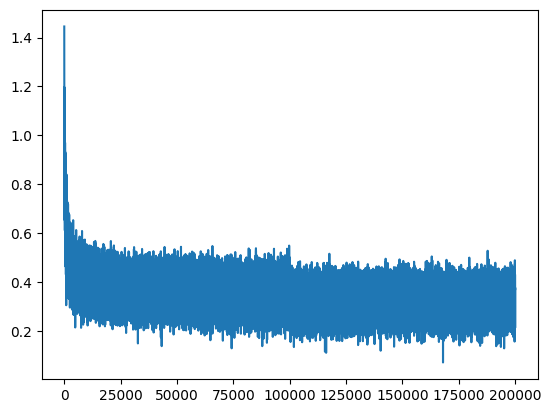

In [14]:
plt.plot(lossi)

Loss for Training Set

In [15]:
emb = C[Xtr] 
h = torch.tanh( emb.view(-1, (embdSize * block_size)) @ W1 + b1 )
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print('Loss for training set: ', loss.item())

Loss for training set:  2.122990846633911


Loss for Development Set

In [16]:
emb = C[Xdev] 
h = torch.tanh( emb.view(-1, (embdSize * block_size)) @ W1 + b1 )
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print('Loss for develoment set: ', loss.item())

Loss for develoment set:  2.1651506423950195


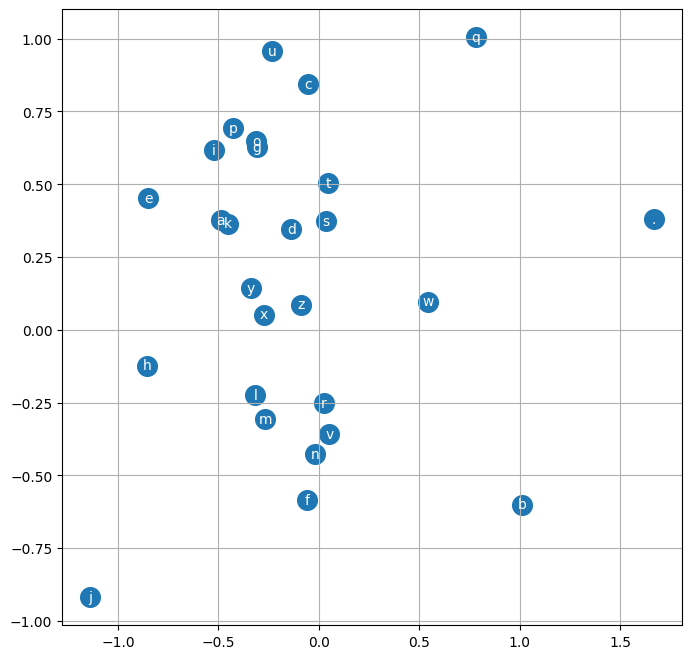

In [17]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Sampling

In [18]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mona.
mayah.
see.
mel.
ryla.
ren.
ruchadrael.
aderronelin.
shi.
jenne.
elionna.
arleit.
kollyan.
noshubergahiriel.
kendreth.
konnie.
casu.
zen.
der.
yarul.
